<h1 style="color:blue; margin-bottom:20px">Предсказание оттока пользователей оператора сотовой связи</h1>

Оператор связи хочет научиться прогнозировать отток клиентов. 

Пользователям, которые планируют уйти, будут предложены промокоды и специальные условия. 
В нашем распоряжении персональные данные о некоторых клиентах, информация об их тарифах и договорах.


В рамках проекта выполним следущие шаги: 

1. [Предобработка и исследовательский анализ  данных](#research)
    - [Выгрузка данных](#download)
    - [Предобработка данных с информацией об интернет услугах](#internet)
    - [Предобработка данных с информацией об интернет услугах](#internet)
    - [Предобработка данных с информацией с персональными данными клиентов](#personal)
    - [Предобработка данных с информацией об услугах телефонии](#phone)

2. [Обучение моделей](#modeling)
    - [Подготовка данных для модели](#prepearing)
    - [LogisticRegression](#log)
    - [DecisionTreeClassifier](#tree)
    - [RandomForestClassifier](#forrest)
    - [LightGBM](#LGBM)
    - [CatBoostClassifier](#CBClassifier)
3. [Проверка лучшей модели](#best)
4. [Вывод](#conc)

<div style="border:solid blue 2px; padding: 20px"> 
<h1 style="color:blue; margin-bottom:20px">Шаг 1. Предобработка и исследовательский анализ  данных</h1>

На данном этапе необходимо выгрузить данные, ознакомиться с ними, оценить количество пропусков проверить на дубликаты, скорректировать форматы, найти закономерности в данных.
Выполним следующие шаги:
    
- [Выгрузка данных](#download)
- [Предобработка данных с информацией об интернет услугах](#internet)
- [Предобработка данных с информацией об интернет услугах](#internet)
- [Предобработка данных с информацией с персональными данными клиентов](#personal)
- [Предобработка данных с информацией об услугах телефонии](#phone)
<a id="research"></a>
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 1.1  Предобработка данных с информацией о договоре</h3>
<a id="download"></a>
</div>

In [1]:
# выгружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re


sns.set_palette('dark')
sns.set_style("dark")

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # Импортировали все модули для классификации

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression # регрессии импортировал на будущее, пусть будут в одном месте

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
#from sklearn.metrics import plot_roc_curve
from sklearn import metrics, model_selection
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score # и импортировали функции для расчета метрик (mean_squared_error тут чтобы не искать)

from sklearn.dummy import DummyClassifier # Этим будем тестировать адекватность модели 

from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb  # импортировали библиотеку для градиентного бустинга
from lightgbm import LGBMRegressor # импортировали модель для обучения регрессии бустингом
from lightgbm import LGBMClassifier

from catboost import CatBoostRegressor # Импортируем еще одну модель градиентного бустинга
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

#contract['uuu'] = contract['TotalCharges'].apply(lambda x:re.sub('[^0-9]','a', x))

In [2]:
# выгружаем датасеты
contract = pd.read_csv('...')
internet = pd.read_csv('...')
personal = pd.read_csv('...')
project_phone = pd.read_csv('...')

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 1.2  Предобработка данных с информацией о договоре</h3>
<a id="contract"></a>
</div>

In [3]:
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
print('Количество дублирующися пользователей: {:.0f}'.format(contract['customerID'].duplicated().sum()))

Количество дублирующися пользователей: 0


 <div style="border:solid grey 1px; padding: 20px"> 
Всего в датасете 7 тыс. наблюдений, 7 признаков. Дублей в данных нет. Форматы выставлены некорректно, нужно поправить форматы в признаках BeginDate, EndDate и TotalCharges На первый взгляд нет и пропусков, но при корректировки форматов удалось обнаружить пропуски в признаках TotalCharges.
</div>

In [6]:
#  выведем наблюдения с пропусками в TotalCharges
contract.sort_values(by = 'TotalCharges').head()

customerID   BeginDate EndDate      Type PaperlessBilling PaymentMethod  \
936   5709-LVOEQ  2020-02-01      No  Two year               No  Mailed check   
3826  3213-VVOLG  2020-02-01      No  Two year               No  Mailed check   
4380  2520-SGTTA  2020-02-01      No  Two year               No  Mailed check   
753   3115-CZMZD  2020-02-01      No  Two year               No  Mailed check   
5218  2923-ARZLG  2020-02-01      No  One year              Yes  Mailed check   

      MonthlyCharges TotalCharges  
936            80.85               
3826           25.35               
4380           20.00               
753            20.25               
5218           19.70

In [7]:
# корректируем форматы
contract['TotalCharges'] = contract['TotalCharges'].apply(pd.to_numeric, errors='coerce')
contract['BeginDate'] = contract['BeginDate'].apply(pd.to_datetime, errors='coerce')

In [8]:
print('Количество пропусков: {:.0f}, нечисловые форматы заменились '\
      .format(contract['TotalCharges'].isnull().sum()))

Количество пропусков: 11, нечисловые форматы заменились 


 <div style="border:solid grey 1px; padding: 20px"> 
Заменим пропуски в TotalCharges на значения из MonthlyCharges. Данные в TotalCharges судя по всему идут накопительным итогом, то есть в TotalCharges указаны все деньги, поступившие за предыдущие периода. У пользователей, которые присоеденились в текущем месяце нет данных в этом столбце. Я решил заполнить эти данные значениями из столбца MonthlyCharges, т.к. фактически деньги уже скорее всего списаны. Также потенциально данные могут быть заполнены нулями, чтобы не нарушать логику данных. Также там моут быть нули, если у них например пробный период.
</div>

In [9]:
# Заменим значения в столбце TotalCharges
contract.loc[contract['TotalCharges'].isnull(), 'TotalCharges'] = contract['MonthlyCharges']

 <div style="border:solid grey 1px; padding: 20px"> 
Создадим новый признак Left, в котором будет значение Yes, если пользователь прекратил пользоваться услугами и No. Этот признак нам в будущем будем предсказывать, скорее всего.
</div>

In [10]:
#  Создаем признак Left
contract['Left']=contract['EndDate']
contract.loc[contract['EndDate'] != 'No', 'Left'] = 'Yes'

In [11]:
contract.head()

customerID  BeginDate              EndDate            Type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Left  
0   No  
1   No  
2  Yes  
3   No  
4  Yes

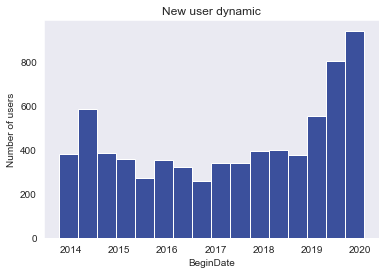

In [12]:
#!pip install seaborn==0.11.0
# если запустить то графики в тренажере запустятся
# отрисуем гистрограмму распределения новых пользователей во времени
sns.histplot(contract['BeginDate'])
plt.title('New user dynamic')
plt.ylabel('Number of users')
plt.show()

 <div style="border:solid grey 1px; padding: 20px"> 
До 2019 года темпы прироста количества новых пользователей оставались примерно на одном уровне, если не учитывать спад через какое-то время после открытия сервиса
</div>

In [13]:
contract1 = contract.query('EndDate != "No"') # уберем все наблюдения со значением No
contract_gr = contract1.groupby('EndDate').agg({'customerID':'count'}) # сгруппируем данные по кол-ву пользователей
                                                                       # ушедших в каждый период времени
contract_gr = contract_gr.reset_index()
contract_gr['EndDate'] = pd.to_datetime(contract_gr['EndDate']) # скорректируем формат на временной
contract_gr['EndDate']= contract_gr['EndDate'].dt.to_period('d') # обрежем 

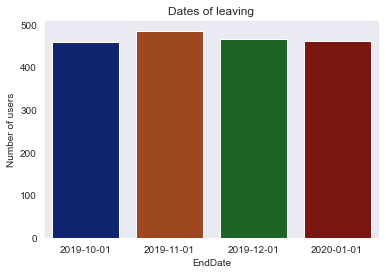

In [14]:
# сформируем столбчатую диаграмму по количеству ушедших пользователей
sns.barplot(data = contract_gr, x = 'EndDate', y = 'customerID')
plt.title('Dates of leaving')
#plt.xticks(rotation = 15)
plt.ylabel('Number of users')
plt.show()

In [15]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

 <div style="border:solid grey 1px; padding: 20px"> 
Уходить пользователи стали только с октября 2019 года, причем довольно стройными рядами, их количетсво почтине меняется. 

Нужен график который поможет соотнести количество приходящих и уходщих пользователей
</div>

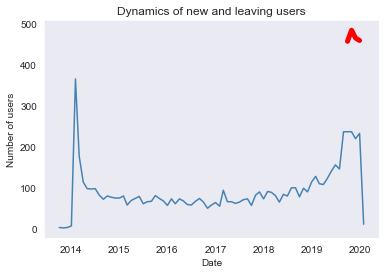

In [16]:
# создадим сводную, в которой будут сгруппированы новые пользователи по дням прихода
newbies = contract.pivot_table(index = 'BeginDate',values = 'customerID', aggfunc = {'customerID':'count'})\
.reset_index()

# отрисуем график прихода новых пользоватей и оттока ушедших
plt.plot(newbies['BeginDate'], newbies['customerID'], color = 'steelblue') # график новых
plt.plot(contract_gr['EndDate'], contract_gr['customerID'], color = 'red', linewidth = 5) # график ушедших
plt.title('Dynamics of new and leaving users')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.show()

 <div style="border:solid grey 1px; padding: 20px"> 
На графике видно что почти все врем существования сервиса ежемесячно приходило примерно 100 новых пользователей, но никто не уходил. В конце сентября стало приходить больше людей, порядка 200-220, но при этом появился очень серьезный отткок - примерно 450 чел в месяц.
    
Что-то очень сильно изменилось в формате предоставления услуг?
</div>

In [17]:
#Напишем функцию, которая будет рисовать нам гистограммы
# по всем данным вместе, и отдельно в разрезе пользователей тарифов
def count_plot(dataframe, column, hues, r_space = 1): 
    plt.figure(figsize = (12,8)) 

    ax1 = plt.subplot(1,2,1) # гистограмма в разрезе категории
    sns.countplot(data=dataframe, y=column, hue=hues)
    plt.title('Countplot plot of '+column+' devided by '+hues)

    ax2 = plt.subplot(1,2,2)# гистограмма без разреза категории
    sns.histplot(data=dataframe, y=column)
    plt.title('Countplot plot of '+column)
    
  
    plt.subplots_adjust(right = r_space, hspace = 0.3)
    plt.suptitle('Countplots plot of '+ column)
    plt.show()

In [18]:
# выберем столбцы для графиков
graphs = ['Type', 'PaperlessBilling', 'PaymentMethod']

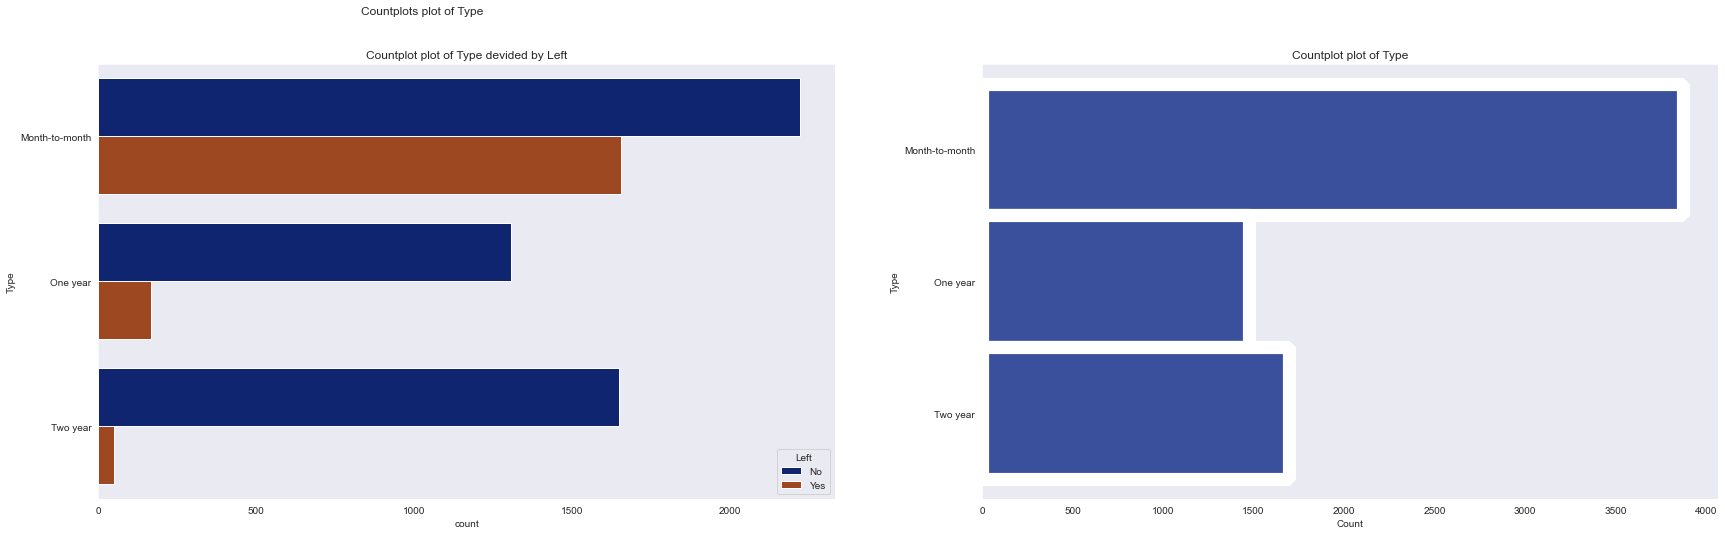

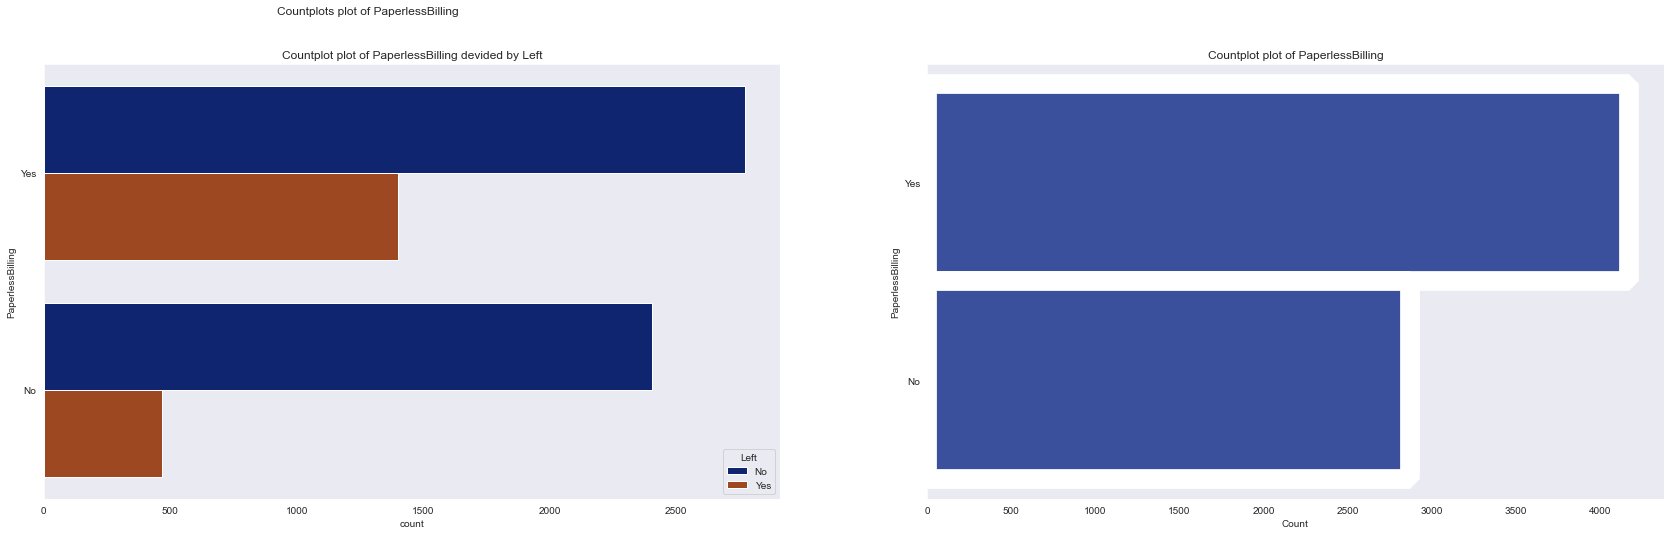

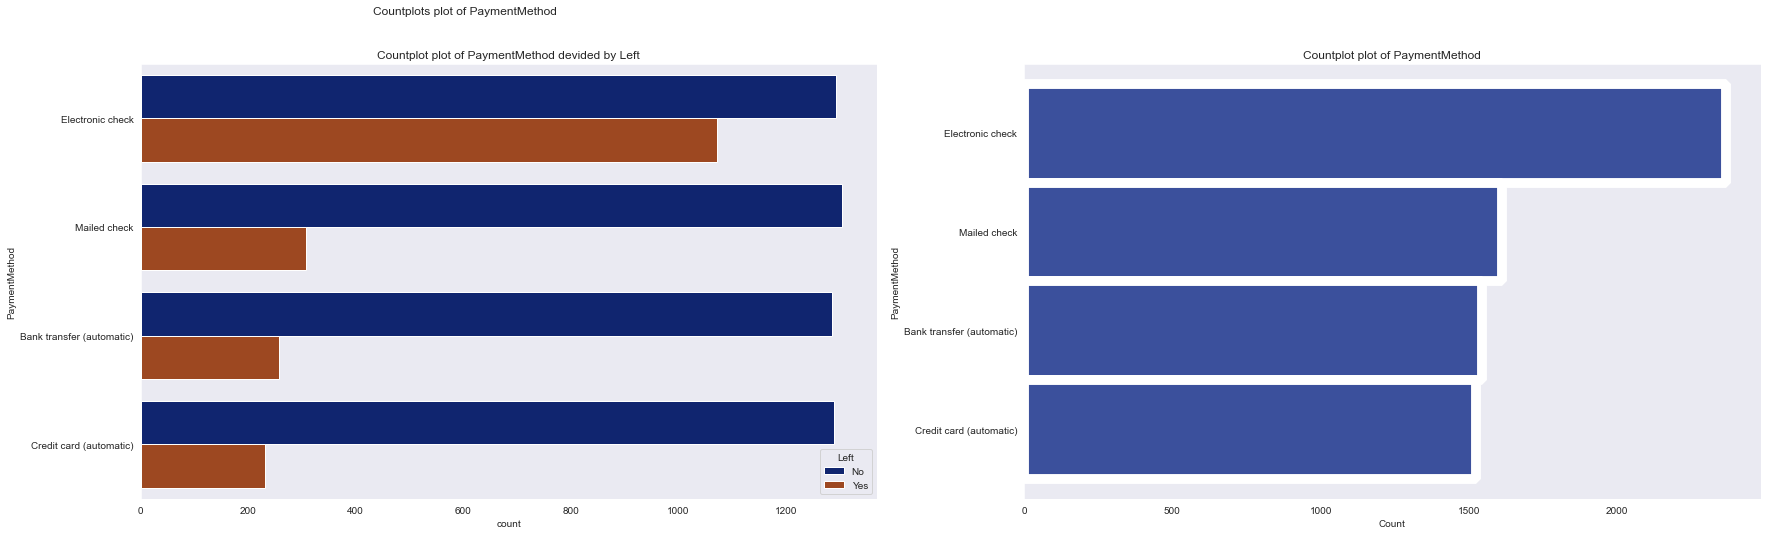

In [19]:
# отрисуем графики количетсва пользователей по категорийным призкам в разрезе ушедших и оставших
# а так же общее соотношение пользователей по категорийным признакам
for i in graphs:
    count_plot(contract, i, 'Left', 2)

 <div style="border:solid grey 1px; padding: 20px"> 
Сильно чаще уходят те, кто платит ежемесячно, что логично, они могут уйти когда пожелают, возможости выхода шире. Нужно привязывать клиентов в долгосрочным подпискам.
Заметно также что чаще уходят те, кто платит черещ Electronic check и использует Paperless billing , не уверен что именно эти факторы играют большую роль при уходе пользвателя, но стоит отметить

</div>

In [20]:
# Напишем функцию, которая будет рисовать нам графики распределения значений и боксплоты
def kde_box(dataframe, column, hues): # В аргументы передаем датафрейм, колонку и столбец детализации
    plt.figure(figsize = (16,8)) # по всем данным вместе и отдельно в разрезе пользователей тарифов

    ax1 = plt.subplot(2,2,1) # гистограмма распределния с детализацией категории
    sns.histplot(data=dataframe, x=column,kde=True, hue=hues)
    plt.title('Hist-KDE plot of '+column+' devided by '+hues)

    ax2 = plt.subplot(2,2,2) # гистограмма распределния без детализации категории
    sns.histplot(data=dataframe, x=column,kde=True)
    plt.title('Hist-KDE plot of '+column)
    
    ax3 = plt.subplot(2,2,3) # боксплот с детализацией категории
    sns.boxplot(data = dataframe, x = hues,  y = column)
    plt.title('Boxplot of '+column)
    
    ax4 = plt.subplot(2,2,4) # боксплот распределния без детализации категории
    sns.boxplot(data = dataframe, y = column)
    plt.title('Boxplot of '+column)
    
    plt.subplots_adjust(right = 1, hspace = 0.3)
    plt.suptitle('Data distribution of '+ column)
    plt.show()

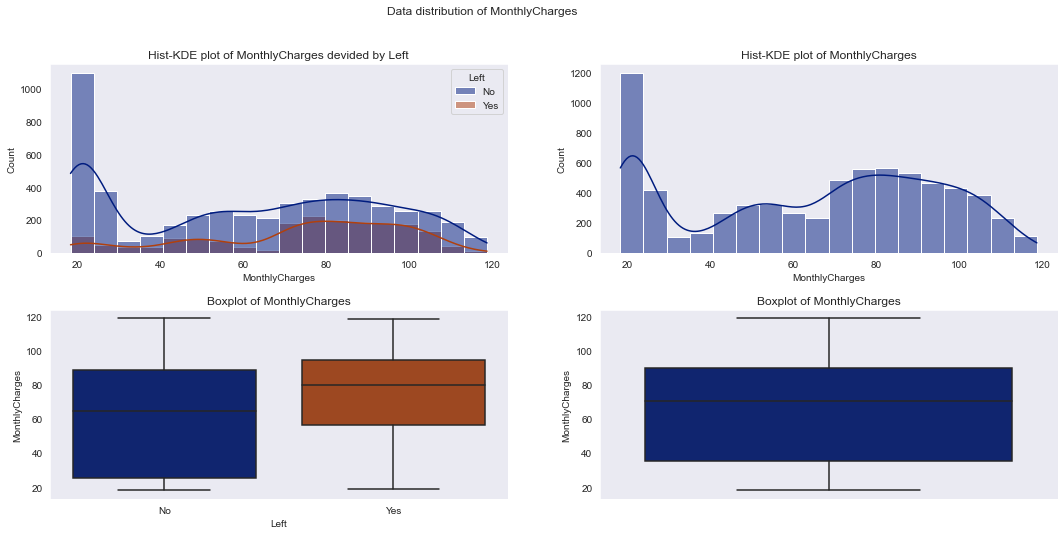

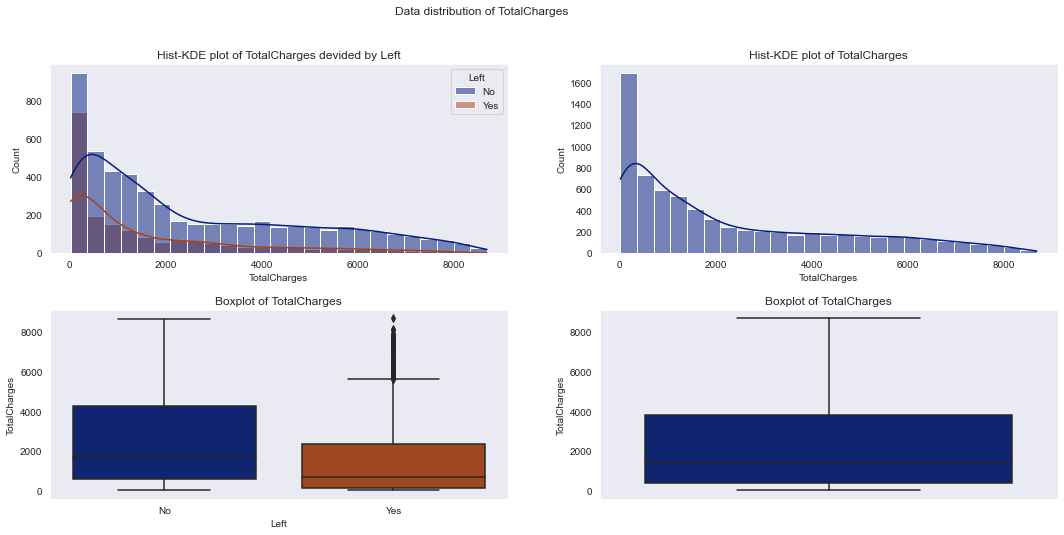

In [21]:
# отрисуем графики распределения количественных признаков в разарезе ущежших и оставшихся пользователей, 
# а также общее распределение количетсвенных признаков
cols = ['MonthlyCharges', 'TotalCharges']
for j in cols:
    kde_box(contract, j, 'Left')

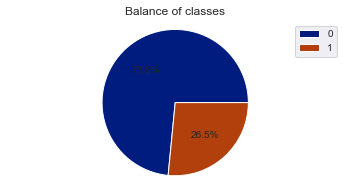

In [22]:
# отрисуем 3 круговые диаграммы с распределением классов внутри выборок
plt.figure(figsize=(6, 3))

plt.pie(contract['Left'].value_counts(), autopct = '%0.1f%%')
plt.axis('equal')
plt.title('Balance of classes')
plt.legend([0,1])

plt.show()

In [23]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Left              7043 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 495.3+ KB


 <div style="border:solid grey 1px; padding: 20px"> 

Распределения показателей ежемесячных и общих выплат у ушедших и оставшихся очень позожи, с той поправкой, что среди оставшихся очень много тех, кто почти ничего не платит.
    
Очень интересно посмотреть на боксплоты. Получается, что что чаще всего уходят те, у кого стоит высокая ежемесячная плата, но при этом они не успели много денег оставить нашей компании. То есть пришли, взяли дорой тариф, посидели немного и ушли. Похоже что часть ушедших - это новые пришедшие во многом. Но ушедших сильно больше, так что не только они.
    
В целом похоже на какую то не очень удачную рекламную компанию или акцию, которая завлекает людей на дорогие услуги, но людт остаются недовольны и уходят.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 1.3  Предобработка данных с информацией об интернет услугах</h3>
<a id="internet"></a>
</div>

In [24]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
# подтянем в таблицу значения признака Left по признаку customerID
full_int = internet.merge(contract[['customerID','Left']], on = 'customerID', how = 'outer')
# пропуски заменили на No т.к. если пользователь не использует доп сервисы он не попадет в эту базу
full_int = full_int.fillna('No') 
full_int.tail()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
7038  4807-IZYOZ              No             No           No               No   
7039  9710-NJERN              No             No           No               No   
7040  9837-FWLCH              No             No           No               No   
7041  0871-OPBXW              No             No           No               No   
7042  2569-WGERO              No             No           No               No   

     TechSupport StreamingTV StreamingMovies Left  
7038          No          No              No   No  
7039          No          No              No   No  
7040          No          No              No   No  
7041          No          No              No   No  
7042          No          No              No   No

In [27]:
print('Количество пропусков: {:.0f}, все значения подтянулись '\
      .format(full_int['Left'].isnull().sum()))

Количество пропусков: 0, все значения подтянулись 


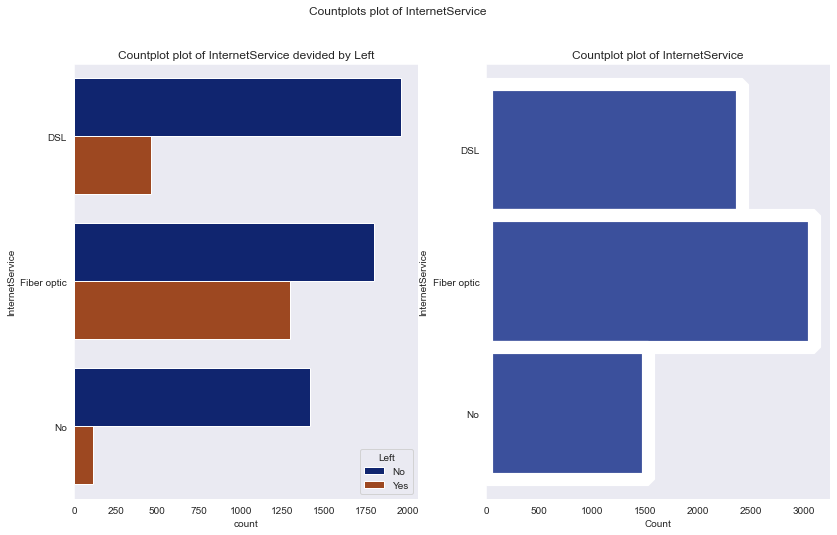

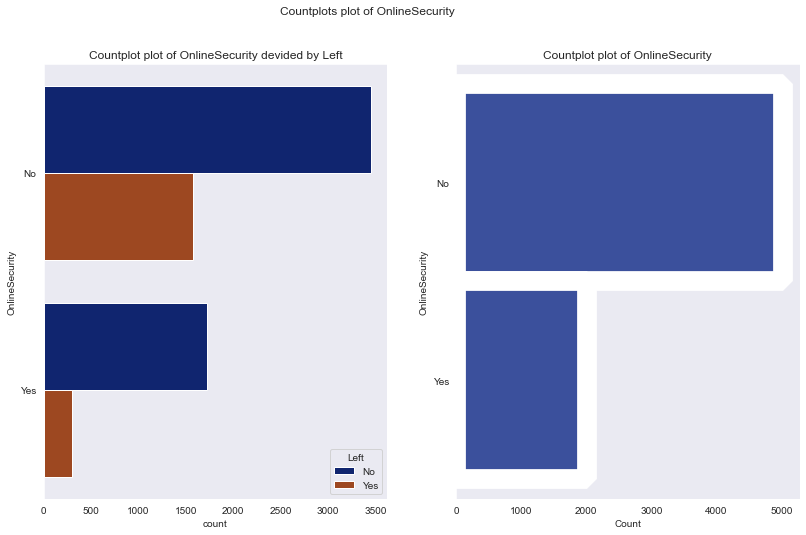

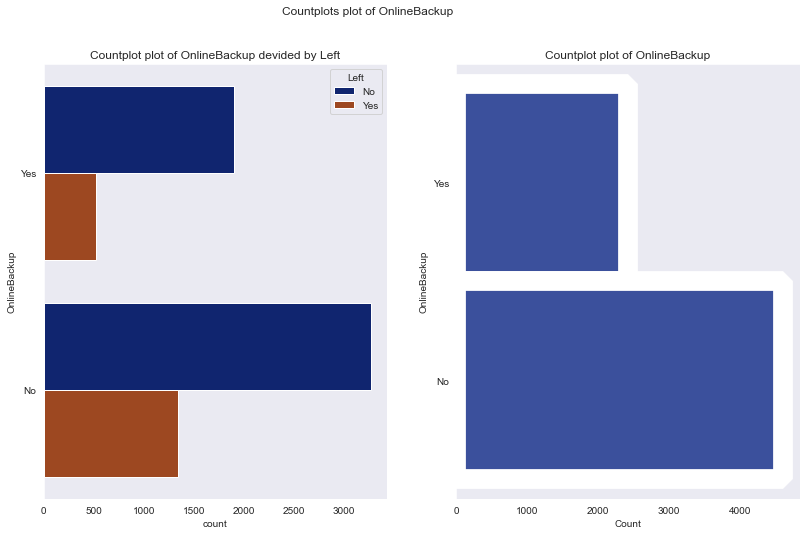

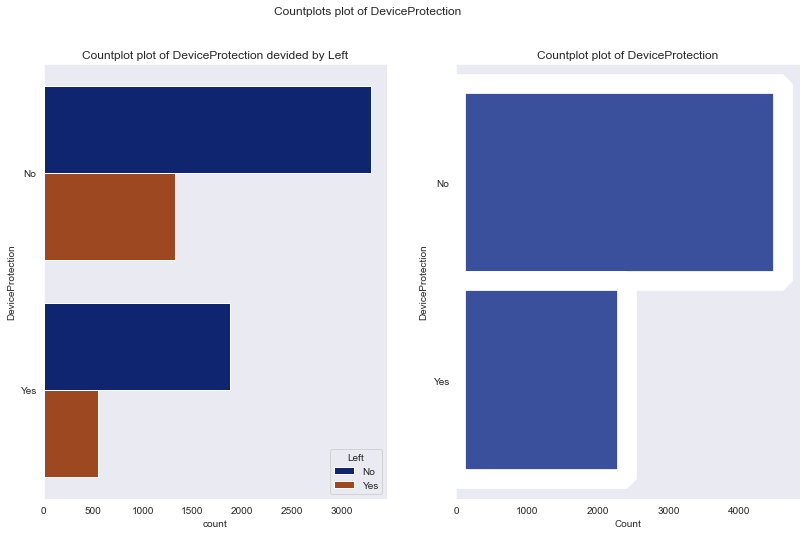

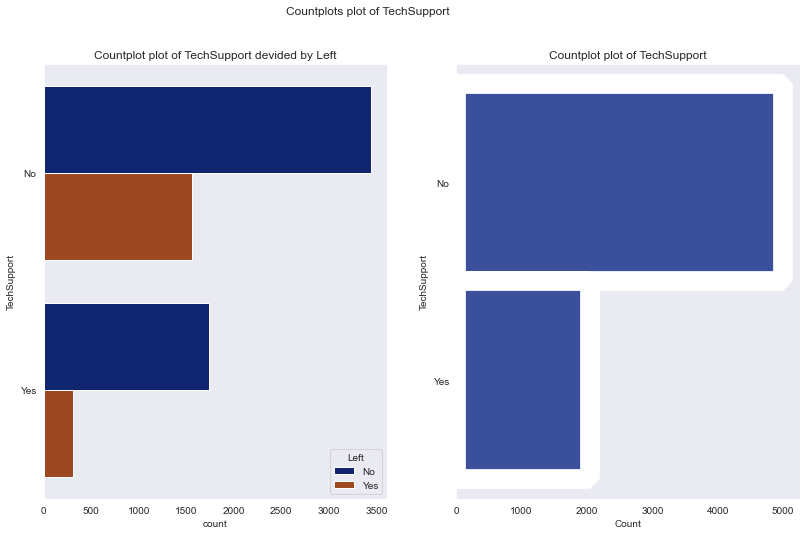

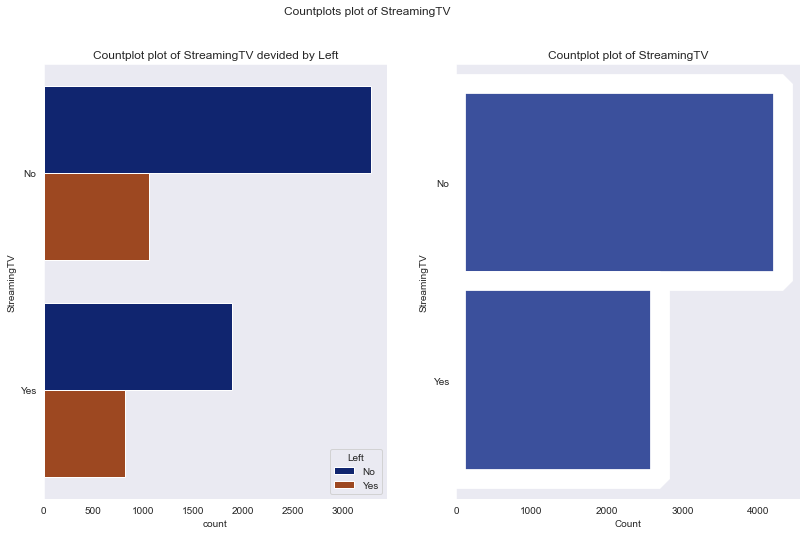

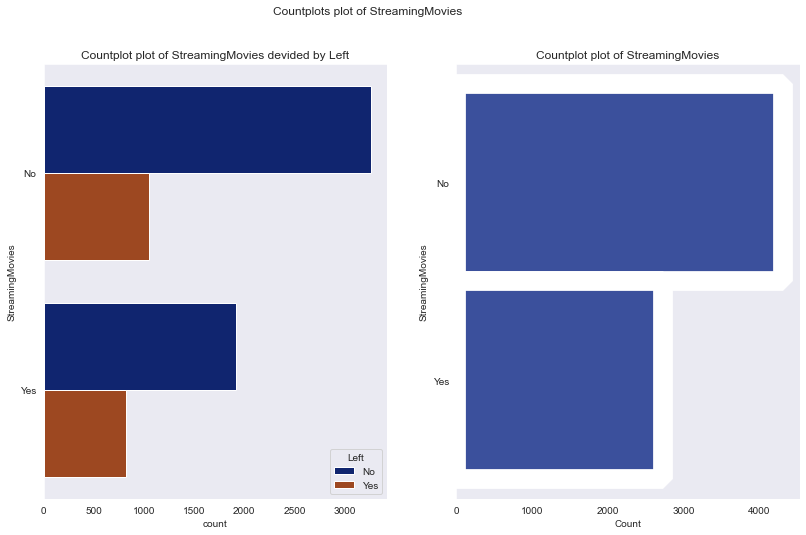

In [28]:
# отрисуем графики количетсва пользователей по категорийным призкам в разрезе ушедших и оставших
# а так же общее соотношение пользователей по категорийным признакам
for column in full_int.drop(['customerID', 'Left'], axis = 1).columns:
    count_plot(full_int, column, 'Left')

 <div style="border:solid grey 1px; padding: 20px"> 
В датасете 5 517 наблюдений, их меньше чем общее числа пользователей т.к. в эту базу попадают не все пользователи, кто-то может не пользваоться услугами по предоставлению интернета.

Данные чистые, без пропусков. Форматы корретны.
    
Если рассматривать интернет услуги, можно увидеть, что чаще в процентном соотношении уходят те, кто используют стримиг фильмов и тв, но это не самая явная зависимость. Четко видно, что уходит очень много тех, кто использует 
оптоволоконный кабель. Может с ним что-то не то?
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 1.4  Предобработка данных с информацией с персональными данными клиентов</h3>
<a id="personal"></a>
</div>

In [29]:
personal.tail()

customerID  gender  SeniorCitizen Partner Dependents
7038  6840-RESVB    Male              0     Yes        Yes
7039  2234-XADUH  Female              0     Yes        Yes
7040  4801-JZAZL  Female              0     Yes        Yes
7041  8361-LTMKD    Male              1     Yes         No
7042  3186-AJIEK    Male              0      No         No

In [30]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [31]:
# подтянем в таблицу значения признака Left по признаку customerID
full_per = personal.merge(contract[['customerID','Left']], on = 'customerID', how = 'outer')
print('Количество пропусков: {:.0f}, все значения подтянулись '\
      .format(full_per['Left'].isnull().sum()))

Количество пропусков: 0, все значения подтянулись 


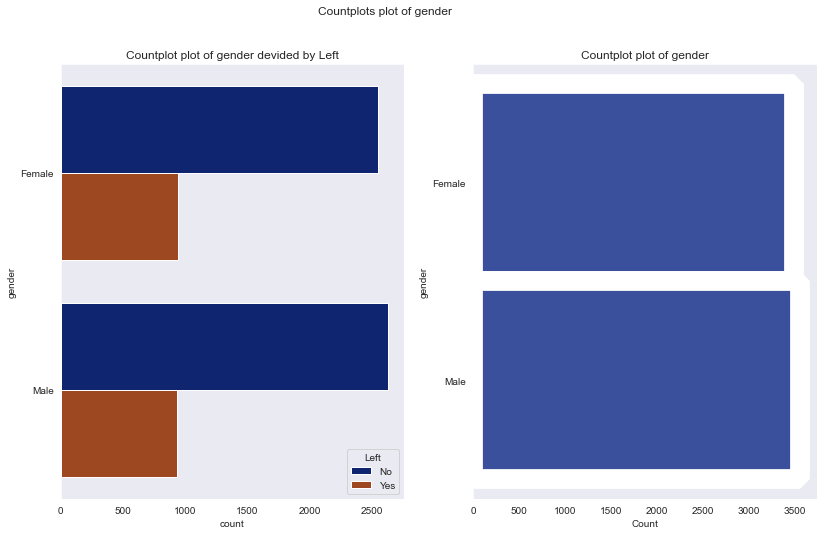

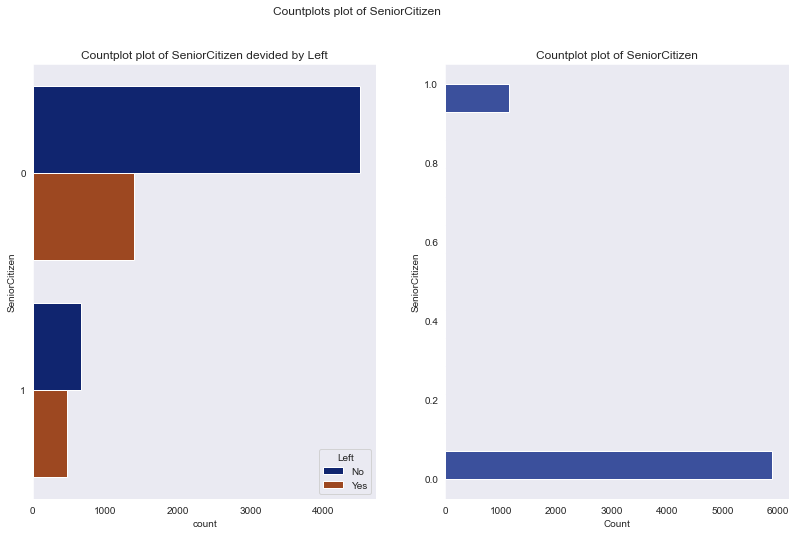

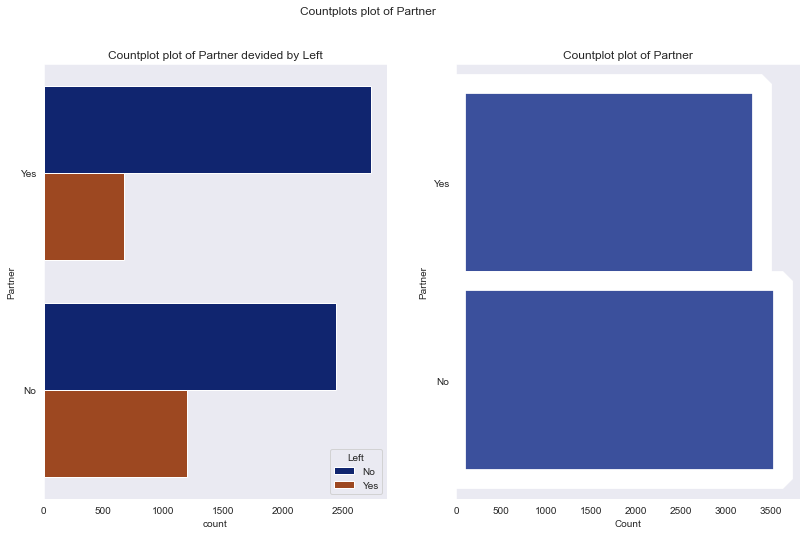

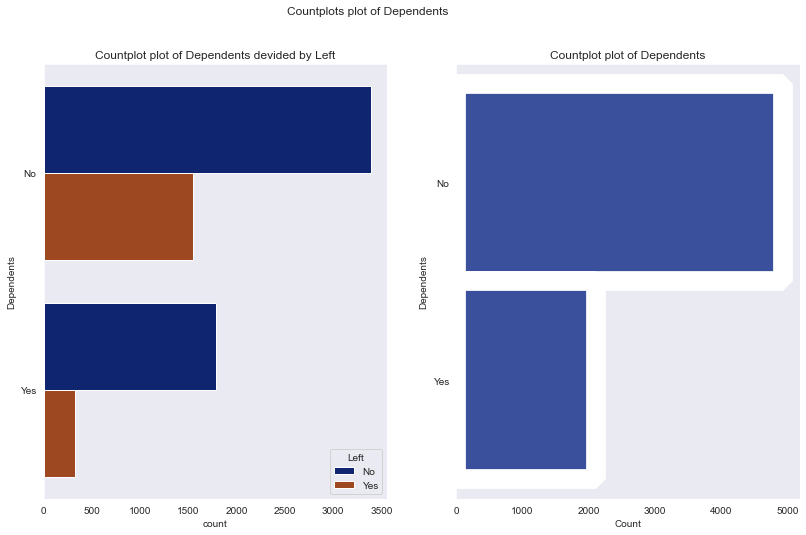

In [32]:
# отрисуем графики количетсва пользователей по категорийным призкам в разрезе ушедших и оставших
# а так же общее соотношение пользователей по категорийным признакам
for column in full_per.drop(['customerID', 'Left'], axis = 1).columns:
    count_plot(full_per, column, 'Left')

In [33]:
# Для единообразия заменим числовые значения на строчные
personal.loc[personal['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'
personal.loc[personal['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'

In [34]:
personal.tail()

customerID  gender SeniorCitizen Partner Dependents
7038  6840-RESVB    Male            No     Yes        Yes
7039  2234-XADUH  Female            No     Yes        Yes
7040  4801-JZAZL  Female            No     Yes        Yes
7041  8361-LTMKD    Male           Yes     Yes         No
7042  3186-AJIEK    Male            No      No         No

 <div style="border:solid grey 1px; padding: 20px"> 
В датасете 7 043 наблюдений, их столько же сколько и в базе контрактов. Данные чистые, без пропусков. Форматы корретны.
    

Если изучать личные данные пользователей, то мы увидим, что часто уходят пожилые пользователи, но это не очень принципиально - их очень мало. Стоит отметить , что гораздно реже уходят Partners и Dependats
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 1.4  Предобработка данных с информацией об услугах телефонии</h3>
<a id="phone"></a>
</div>

In [35]:
project_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [36]:
project_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [37]:
# подтянем в таблицу значения признака Left по признаку customerID
full_proj = project_phone.merge(contract[['customerID','Left']], on = 'customerID', how = 'outer')
print('Количество пропусков: {:.0f}, все значения подтянулись '\
      .format(full_proj['Left'].isnull().sum()))
print()
print('Количество пропусков: {:.0f},  в таблице contract пользователей больше чем в таблице project_phone'\
      .format(full_proj['MultipleLines'].isnull().sum()))


Количество пропусков: 0, все значения подтянулись 

Количество пропусков: 682,  в таблице contract пользователей больше чем в таблице project_phone


In [38]:
full_proj['MultipleLines'] = full_proj['MultipleLines'].fillna('No')
full_proj.tail()

customerID MultipleLines Left
7038  4501-VCPFK            No   No
7039  2274-XUATA            No   No
7040  2235-DWLJU            No   No
7041  7750-EYXWZ            No   No
7042  4801-JZAZL            No   No

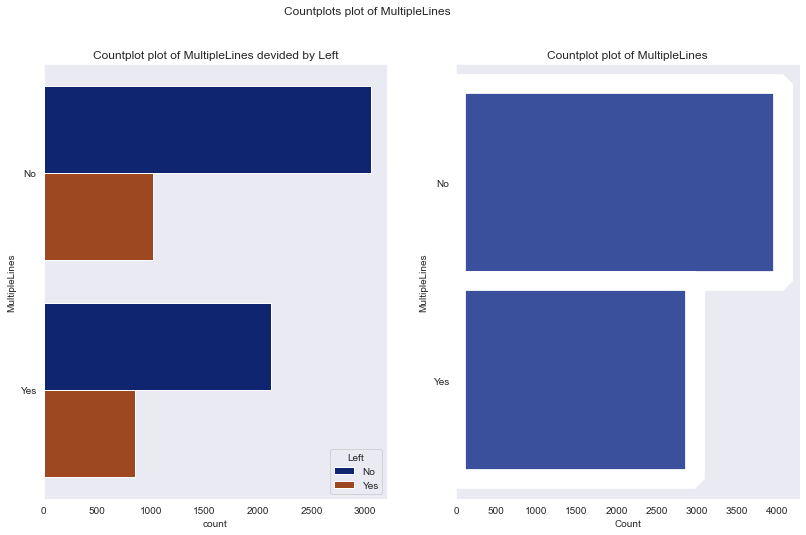

In [39]:
# отрисуем графики количетсва пользователей по категорийным призкам в разрезе ушедших и оставших
# а так же общее соотношение пользователей по категорийным признакам
count_plot(full_proj, 'MultipleLines', 'Left')

 <div style="border:solid grey 1px; padding: 20px"> 
В датасете 6 361 наблюдений, их меньше чем общее числа пользователей.Скорее всего это пользователи, которые не используют телефонию. Сложно сказать, почему они не попали в эту базу. Нужно запросить информацию у администратора базы.

Данные чистые, без пропусков. Форматы корретны.
    
Большой разницы в потребительском поведении тех кто пользуется и нет телефонией нет
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h1 style="color:blue; margin-bottom:20px">Шаг 2. Обучение моделей</h1>

На данном этапе необходимо обучить несколько моделей, сравнить их качество и определить лучшие. Будут исследованы следующие модели и выполнены следующие шаги:
    
- [Подготовка данных для модели](#prepearing)
- [LogisticRegression](#log)
- [DecisionTreeClassifier](#tree)
- [RandomForestClassifier](#forrest)
- [LightGBM](#LGBM)
- [CatBoostClassifier](#CBClassifier)
<a id="modeling"></a>
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 2.1  Подготовка данных для модели</h3>
<a id="prepearing"></a>
</div>

In [40]:
# Объеденим все данные в один датасет
data = contract.merge(internet, on = 'customerID', how = 'outer')\
               .merge(personal, on = 'customerID', how = 'outer')\
               .merge(project_phone, on = 'customerID', how = 'outer')

# Задали переменную с полседним днем когда пришли новые пользователи
today = pd.to_datetime('2020-02-01')

data['EndDate'] = pd.to_datetime(data['EndDate'], errors='coerce') # скорректировали формат призанака EndDate
# Рассчитаем сколько дней каждый пользователь пользуется сервисом
data['Duration'] = data['EndDate'].mask(data['EndDate'].isna(), today)-data['BeginDate'] 
data['Duration'] = (data['Duration']).dt.days.astype('Int64') # корректируем формат

# задали новый признак исходя из типа оплаты
data.loc[data['Type'] != 'Month-to-month', 'Type'] = 'Longterm'
#  признак по типу чека
data.loc[data['PaymentMethod'] != 'Electronic check', 'PaymentMethod'] = 'Other'

 # признак по ежемесячно оплате клиента
data['Client_cat'] = 1
data.loc[data['MonthlyCharges'] < 70 , 'Client_cat'] = 'Cheap'
data.loc[data['MonthlyCharges'] >= 70 , 'Client_cat'] = 'Expensive'

# уберем customerID (он не нужен для модели) и EndDate, мы его заменили на целевой признак Left
data = data.drop(['customerID', 'EndDate', 'BeginDate', 'MultipleLines', 'DeviceProtection',\
                 'OnlineBackup', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',\
                 'StreamingTV', 'StreamingMovies', 'PaperlessBilling'], axis = 1) 
data = data.fillna('No') # Как и в предобработка заменим все неподтянувшиеся данные на No

print('Количество признаков в датасете для подготовки модели: {:.0f}'.format(data.shape[1]))

Количество признаков в датасете для подготовки модели: 10


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             7043 non-null   object 
 1   PaymentMethod    7043 non-null   object 
 2   MonthlyCharges   7043 non-null   float64
 3   TotalCharges     7043 non-null   float64
 4   Left             7043 non-null   object 
 5   InternetService  7043 non-null   object 
 6   OnlineSecurity   7043 non-null   object 
 7   TechSupport      7043 non-null   object 
 8   Duration         7043 non-null   Int64  
 9   Client_cat       7043 non-null   object 
dtypes: Int64(1), float64(2), object(7)
memory usage: 612.1+ KB


<div style="border:solid grey 1px; padding: 20px"> 
Данные соеденились корректно. Форматы корректные, пропусков нет. Интересно, что у нас всего 2 количественных признака, один временной и 16 качественных.

Можем переходить к кодированию данных.
</div>

<div style="border:solid grey 1px; padding: 20px"> 
Кодировать будем методом One-Hot Encoding. Все качественные признаки у нас обычно предствлены 2-3 вариантмами, так что датасет это очень сильно раздуть не должно

Кодировать будем сразу все данные, до их разбивки на train test, т.к. данные тут обучать не нужно
</div>

In [42]:
numeric = [] #добавим в всписок все не категорийные признаки, сделаем это до прямого кодирования, когда все превратится в числа

for col in data.drop('Left', axis=1).columns.tolist(): # Циклом переберем все столбцы, и оставим те
    if data[col].dtype != 'object' and data[col].dtype != 'datetime64[ns]': #   , где ти не object
        numeric.append(col)
numeric

['MonthlyCharges', 'TotalCharges', 'Duration']

In [43]:
data = pd.get_dummies(data, drop_first = True) # Кодируем методом One-Hot Encoding
data = data.rename(columns = {'Left_Yes':'Left'}) # переименовали обратно целевой столбец

In [44]:
print('Количество признаков в датасете для подготовки модели: {:.0f}'.format(data.shape[1]))

Количество признаков в датасете для подготовки модели: 11


<div style="border:solid grey 1px; padding: 20px"> 
    
Теперь отделим целевой признак от остальных
</div>

In [45]:
features = data.drop('Left', axis = 1) # Разделили признаки на обычные и целевой
target = data['Left']

In [46]:
# взяли 20% данных в валидационную выборку, сделали стратификацю, 
# чтобы классы распределились также как в исходном датасете

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size = 0.2, random_state = 12345, stratify=target) 

In [47]:
data_list = [features_train, features_test]
for data_set in data_list:
    percent = data_set.shape[0]/data.shape[0]
    objects = data_set.shape[0]
    signs = data_set.shape[1]
    print('Количество объектов в выборке составляет {},доля от общей выборки составляет {:.2%} количество признаков {}.'\
          .format(objects,percent, signs))
# проверим, что выборки 60-20-20

Количество объектов в выборке составляет 5634,доля от общей выборки составляет 79.99% количество признаков 10.
Количество объектов в выборке составляет 1409,доля от общей выборки составляет 20.01% количество признаков 10.


In [48]:
# создали фреймы с количеством каждого класса в процентах для каждой выборки
left_train = target_train.value_counts().to_frame().reset_index() #normalize = True
left_test = target_test.value_counts().to_frame().reset_index()

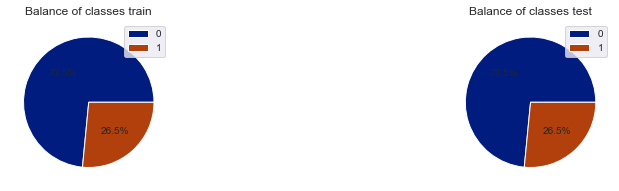

In [49]:
# отрисуем 3 круговые диаграммы с распределением классов внутри выборок
plt.figure(figsize=(6, 3))

plt.subplot(1,2,1)
plt.pie(left_train['Left'], autopct = '%0.1f%%')
#plt.axis('equal')
plt.title('Balance of classes train')
plt.legend(left_train['index'])

plt.subplot(1,2,2)
plt.pie(left_train['Left'], autopct = '%0.1f%%')
#plt.axis('equal')
plt.title('Balance of classes test')
plt.legend(left_train['index'])

plt.subplots_adjust(right = 2)
plt.show()

In [50]:
scaler = StandardScaler() # Проводим стандартизацию данных
scaler.fit(features_train[numeric]) #Обучаем на трейне 

features_train[numeric] = scaler.transform(features_train[numeric]) # Кодируем трейн
features_test[numeric] = scaler.transform(features_test[numeric]) # Кодируем тест

In [51]:
def scorers(dicts): # возращает среднее значение словаря по ключу
    for key in list(dicts.keys()): # используется для класса cross_validate
        print('{}: {:.3f}'.format(key, np.mean(dicts.get(key))))

<div style="border:solid grey 1px; padding: 20px"> 
    
Создали новые признаки которые указыают к какой категории относится тот или иной клиент в зависимости от объема ежемесячного платежа, платит ли клиент ежемясячно или раз в год и реже. Также убрали большое количество малозначимых признаков, в основном они связаны либо с персональными данными или типосм интернет услуг.
    
Также данные были закодированы, нормированы и разделены на выборки с учетом баланса классаов.
</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 2.1  Обучение LogisticRegression</h3>
<a id="log"></a>
</div>

In [52]:
# Обучим логистическую регрессию
model = LogisticRegression(random_state = 12345, class_weight='balanced')

LogReg = \
cross_validate(model, features_train, target_train, cv = 3, \
               scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision'])

In [53]:
# выведем показатели модели
scorers(LogReg)

fit_time: 0.013
score_time: 0.005
test_accuracy: 0.751
test_precision: 0.521
test_recall: 0.794
test_f1: 0.629
test_roc_auc: 0.842
test_average_precision: 0.650


In [54]:
# напишем функцию  для графиков ROC-кривой и  Precision-Recall, чтобы не загромождать все кодом в будущем
def curve_graphs(answers, probability): # аргументы: целевой показатель и вероятности predict_proba

    plt.figure(figsize=(6, 6))

    fpr, tpr, thresholds = roc_curve(answers, probability) # считаем  метрики с разным трешходом
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')

    precision, recall, thresholds = precision_recall_curve(answers, probability) # считаем  метрики с разным трешходом
    plt.subplot(1,2,2)
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')

    plt.subplots_adjust(right = 2)
    plt.show()

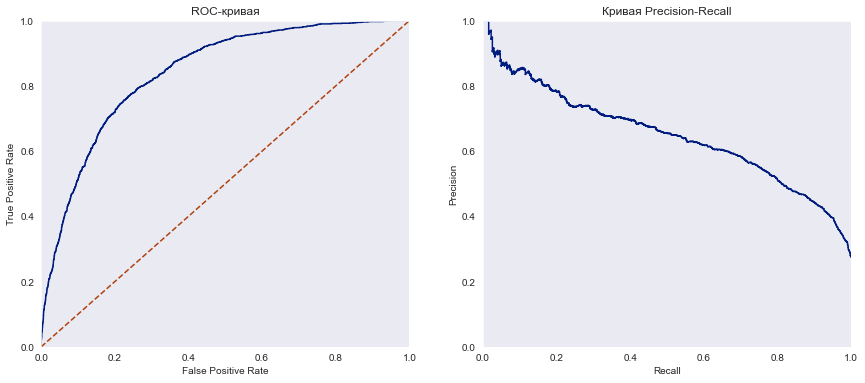

In [55]:
cur =\
cross_val_predict(model, features_train, target_train, cv = 3, method='predict_proba')[:,1]
curve_graphs(target_train, cur)

In [56]:
# напишем функцию  матрицы ошибок, чтобы не загромождать все кодом в будущем
def conf_mat(answers, predictions, classes): # аргументы: целевой показатель, предсказания, классы
    plt.figure(figsize = (8,6))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(answers, predictions), annot = True,fmt= '.0f', linewidths=1, linecolor='grey')
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.xlabel('Predictions')
    plt.ylabel('Answers')
    plt.title('Confusion matrix')
    plt.show()

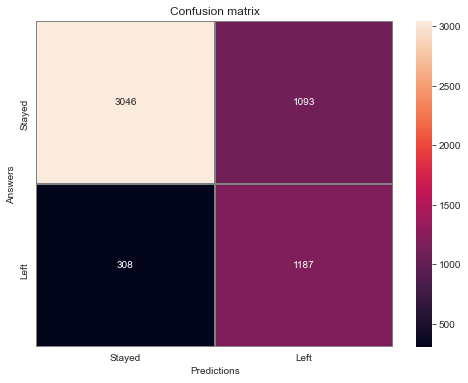

In [57]:
proba = cross_val_predict(model, features_train, target_train, cv = 3)
conf_mat(target_train, proba, ['Stayed', 'Left']) # Left

<div style="border:solid grey 1px; padding: 20px"> 
Модель логистической регрессии на кросс-валидации данных получила roc_auc 0.842 и accuracy 0.799.
Модель показывает довольно высокий показатель recall 0.794 и средний precision: 0.521, то есть модель определяет 79% всех уходящих пользователей, но почти 50% из тех кого модель определяет как уходящих на самом деле не уходят
</div>

In [58]:
# Создадим датафрейм с результатами модели, потом так будет проще искать лучшую модель
log_table = pd.DataFrame.from_dict(LogReg).T
log_table['LogReg'] = (log_table[0]+log_table[1]+log_table[2])/3
log_table = log_table.drop([0,1,2], axis = 1)
log_table

LogReg
fit_time                0.013330
score_time              0.005445
test_accuracy           0.751331
test_precision          0.521413
test_recall             0.793978
test_f1                 0.628989
test_roc_auc            0.841755
test_average_precision  0.650019

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 2.2  Обучение DecisionTreeClassifier</h3>
<a id="tree"></a>
</div>

In [59]:
best_roc_auc_tree = [0] # создадим списки для результатов модели
best_depth_tree = [1000]
best_model_tree = [1]
best_scores_tree = [0]
roc_auc=0
for depth in list(range(1,25)): # перебираем высоту дерева
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345, class_weight='balanced')

    scores = cross_validate(model, features_train, target_train, cv=3, \
                            scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision'])
    roc_auc = np.mean(scores.get('test_roc_auc')) # рассчитали roc_auc модели
    if roc_auc>best_roc_auc_tree[-1]:
        best_roc_auc_tree.append(roc_auc)
        best_depth_tree.append(depth)
        best_model_tree.append(model)
        best_scores_tree.append(scores)
        

In [60]:
scorers(best_scores_tree[-1])

fit_time: 0.006
score_time: 0.005
test_accuracy: 0.771
test_precision: 0.552
test_recall: 0.761
test_f1: 0.639
test_roc_auc: 0.846
test_average_precision: 0.677


In [61]:
print('Лучшие показатели модели')
print("Глубина = {:.0f} | best_roc_auc_tree {:.2f}"\
      .format(best_depth_tree[-1] ,best_roc_auc_tree[-1]))

Лучшие показатели модели
Глубина = 6 | best_roc_auc_tree 0.85


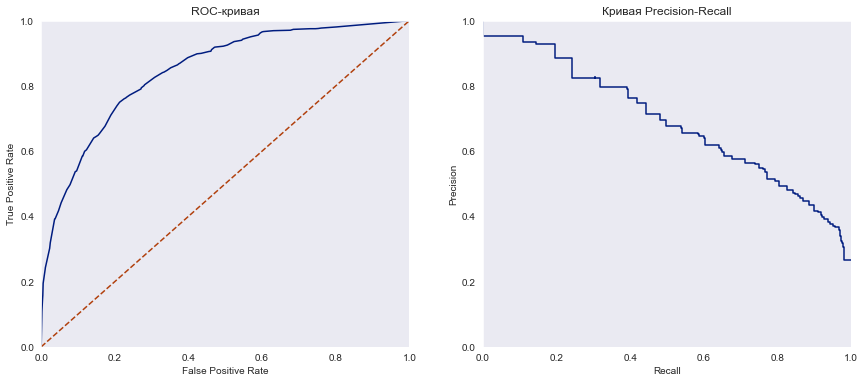

In [62]:
for_curce = cross_val_predict(best_model_tree[-1], features_train, target_train, cv = 3, method='predict_proba')[:,1]
curve_graphs(target_train, for_curce)

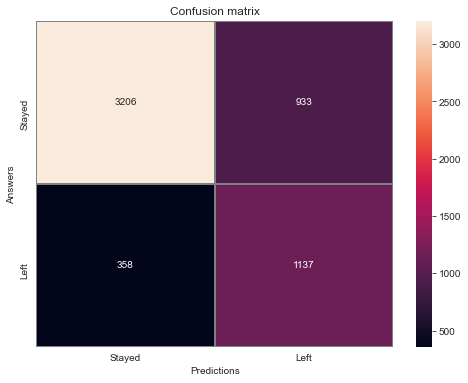

In [63]:
for_mat_tree = cross_val_predict(best_model_tree[-1], features_train, target_train, cv = 3)
conf_mat(target_train, for_mat_tree, ['Stayed', 'Left'])

In [64]:
# Создадим датафрейм с результатами модели, потом так будет проще искать лучшую модель
tree_table = pd.DataFrame.from_dict(best_scores_tree[-1]).T
tree_table['DecisionTreeClassifier'] = (tree_table[0]+tree_table[1]+tree_table[2])/3
tree_table = tree_table.drop([0,1,2], axis = 1)
tree_table

DecisionTreeClassifier
fit_time                              0.006359
score_time                            0.004766
test_accuracy                         0.770856
test_precision                        0.552170
test_recall                           0.760526
test_f1                               0.638608
test_roc_auc                          0.845637
test_average_precision                0.676830

<div style="border:solid grey 1px; padding: 20px"> 
Модель решающего дерева с гиперпараметрами depth = 6 на кросс-валидации данных получила roc_auc 0.846 и accuracy 0.771.
Модель показывает довольно хороший показатель recall 0.761 и средний precision: 0.552, то есть модель определяет 76% всех уходящих пользователей, но почти 45% из тех кого модель определяет как уходящих на самом деле не уходят.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 2.3 Обучение RandomForestClassifier</h3>
<a id="forrest"></a>
</div>

In [65]:
best_roc_auc_forrest = [0] # создадим списки для результатов модели
best_depth_forrest = [1000]
best_estimator_forest = [0]
best_model_forrest = [1]
best_scores_forrest = [0]
roc_auc=0
for estimator in list(range(110, 130, 5)):
    for depth in list(range(6,9)): # перебираем высоту дерева
        model = RandomForestClassifier\
        (n_estimators = estimator, max_depth = depth, random_state = 12345, class_weight='balanced')

        scores = cross_validate(model, features_train, target_train, cv=3, \
                                scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision'])
        roc_auc = np.mean(scores.get('test_roc_auc')) # рассчитали roc_auc модели
        if roc_auc>best_roc_auc_forrest[-1]:
            best_roc_auc_forrest.append(roc_auc)
            best_depth_forrest.append(depth)
            best_estimator_forest.append(estimator)
            best_model_forrest.append(model)
            best_scores_forrest.append(scores)

In [66]:
scorers(best_scores_forrest[-1])

fit_time: 0.224
score_time: 0.044
test_accuracy: 0.789
test_precision: 0.582
test_recall: 0.741
test_f1: 0.651
test_roc_auc: 0.861
test_average_precision: 0.720


In [67]:
print('Лучшие показатели модели')
print("Деревья = {:.0f} | Глубина = {:.0f} |test_roc_auc {:.3f}"\
      .format(best_estimator_forest[-1], best_depth_forrest[-1] , np.mean(best_scores_forrest[-1].get('test_roc_auc'))))

Лучшие показатели модели
Деревья = 110 | Глубина = 8 |test_roc_auc 0.861


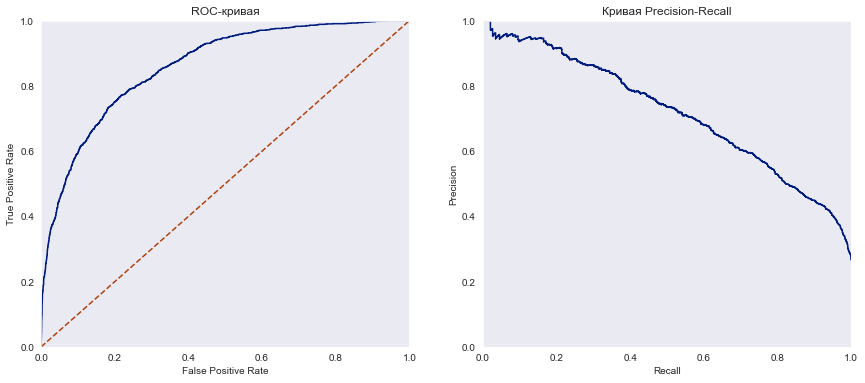

In [68]:
for_curce = cross_val_predict(best_model_forrest[-1], features_train, target_train, cv = 3, method='predict_proba')[:,1]
curve_graphs(target_train, for_curce)

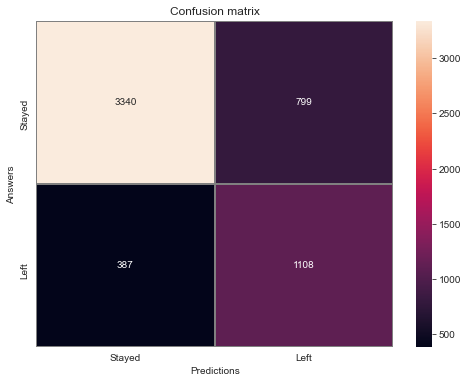

In [69]:
for_mat_for = cross_val_predict(best_model_forrest[-1], features_train, target_train, cv = 3)
conf_mat(target_train, for_mat_for, ['Stayed', 'Left'])

In [70]:
# Создадим датафрейм с результатами модели, потом так будет проще искать лучшую модель
for_table = pd.DataFrame.from_dict(best_scores_forrest[-1]).T
for_table['forrest'] = (for_table[0]+for_table[1]+for_table[2])/3
for_table = for_table.drop([0,1,2], axis = 1)
for_table

forrest
fit_time                0.224254
score_time              0.044078
test_accuracy           0.789492
test_precision          0.581745
test_recall             0.741146
test_f1                 0.651284
test_roc_auc            0.860729
test_average_precision  0.720346

In [71]:
best_model_forrest[-1].fit(features_train, target_train)
importances = best_model_forrest[-1].feature_importances_

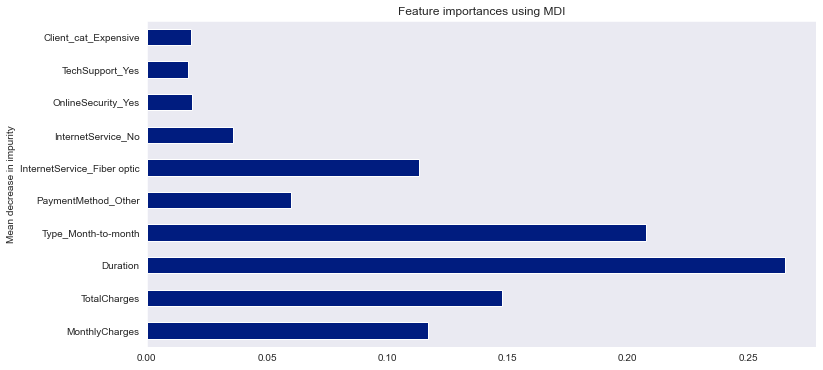

In [72]:
forest_importances = pd.Series(importances, index=features_train.columns)

plt.figure(figsize = (12,6))
forest_importances.plot(kind = 'barh')
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")

plt.show()

<div style="border:solid grey 1px; padding: 20px"> 
Модель случайного леса с гиперпараметрами Деревья = 110 | Глубина = 8  на кросс-валидации данных получила roc_auc 0.861 и accuracy 0.789.
Модель показывает довольно хороший показатель recall 0.741 и средний precision: 0.582, то есть модель определяет 74% всех уходящих пользователей, но почти 42% из тех кого модель определяет как уходящих на самом деле не уходят.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 2.4 Обучение LightGBM</h3>
<a id="LGBM"></a>
</div>

In [73]:
best_roc_auc_lgbm = [0] # создадим списки для результатов модели
best_depth_lgbm = [1000]
best_estimator_lgbm = [0]
best_model_lgbm = [1]
best_scores_lgbm = [0]
roc_auc=0
for estimator in list(range(90, 91, 5)):
    for depth in list(range(5,6)): # перебираем высоту дерева
        model = LGBMClassifier(learning_rate=0.5, max_depth=depth, num_leaves=8,\
                       n_estimators=estimator, random_state = 12345, is_unbalance=True)

        scores = cross_validate(model, features_train, target_train, cv=3, \
                                scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision'])
        roc_auc = np.mean(scores.get('test_roc_auc')) # рассчитали RMSE модели
        if roc_auc>best_roc_auc_lgbm[-1]:
            best_roc_auc_lgbm.append(roc_auc)
            best_depth_lgbm.append(depth)
            best_estimator_lgbm.append(estimator)
            best_model_lgbm.append(model)
            best_scores_lgbm.append(scores)

In [74]:
scorers(best_scores_lgbm[-1])

fit_time: 0.032
score_time: 0.011
test_accuracy: 0.827
test_precision: 0.644
test_recall: 0.779
test_f1: 0.705
test_roc_auc: 0.900
test_average_precision: 0.806


In [75]:
print('Лучшие показатели модели')
print("Деревья = {:.0f} | Глубина = {:.0f} | roc_auc {:.3f}"\
      .format(best_estimator_lgbm[-1], best_depth_lgbm[-1] , np.mean(best_scores_lgbm[-1].get('test_roc_auc'))))

Лучшие показатели модели
Деревья = 90 | Глубина = 5 | roc_auc 0.900


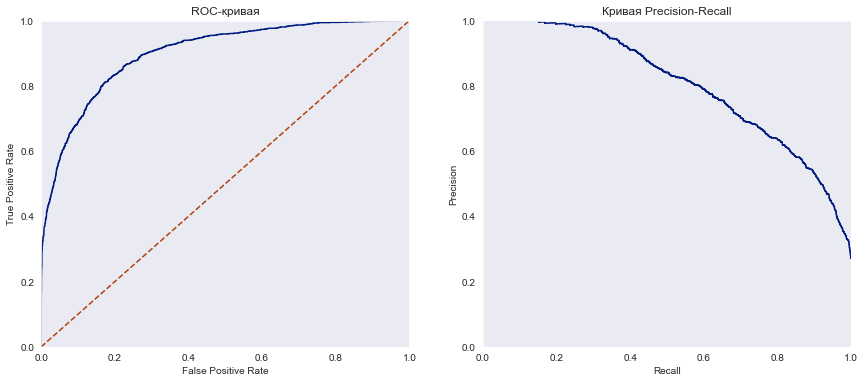

In [76]:
lgbm_curce = cross_val_predict(best_model_lgbm[-1], features_train, target_train, cv = 3, method='predict_proba')[:,1]
curve_graphs(target_train, lgbm_curce)

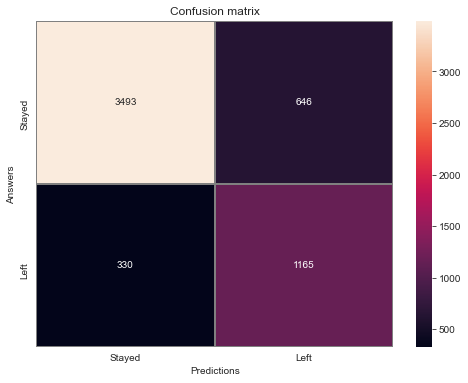

In [77]:
lgbm_mat_for = cross_val_predict(best_model_lgbm[-1], features_train, target_train, cv = 3)
conf_mat(target_train, lgbm_mat_for, ['Stayed', 'Left'])  

In [78]:
# Создадим датафрейм с результатами модели, потом так будет проще искать лучшую модель
lgbm_table = pd.DataFrame.from_dict(best_scores_lgbm[-1]).T
lgbm_table['lgbm'] = (lgbm_table[0]+lgbm_table[1]+lgbm_table[2])/3
lgbm_table = lgbm_table.drop([0,1,2], axis = 1)
lgbm_table

lgbm
fit_time                0.031628
score_time              0.011406
test_accuracy           0.826766
test_precision          0.643683
test_recall             0.779285
test_f1                 0.704813
test_roc_auc            0.899902
test_average_precision  0.806353

In [79]:
best_model_lgbm[-1].fit(features_train, target_train)
importances = best_model_lgbm[-1].feature_importances_

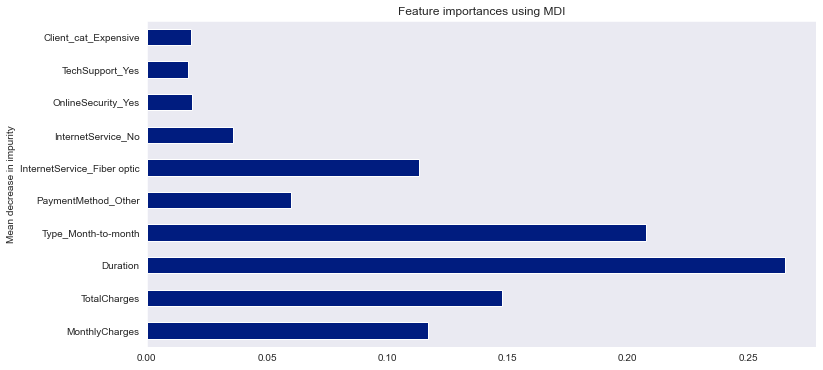

In [80]:
lgbm_importances = pd.Series(importances, index=features_train.columns)

plt.figure(figsize = (12,6))
forest_importances.plot(kind = 'barh')
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")

plt.show()

<div style="border:solid grey 1px; padding: 20px"> 
Модель градиентного бустинга LightGBM гиперпараметрами Деревья = 90 | Глубина = 5  на кросс-валидации данных получила roc_auc 0.9 и accuracy 0.827.
Модель показывает довольно хороший показатель recall 0.779 и средний precision: 0.644, то есть модель определяет 77,9% всех уходящих пользователей, но почти 36% из тех кого модель определяет как уходящих на самом деле не уходят.
    
Эта модель показывает пока самые качественные метрики.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 2.5 Обучение CatBoostClassifier</h3>
<a id="CBClassifier"></a>
</div>

In [81]:
best_roc_auc_cat = [0] # создадим списки для результатов модели
best_depth_cat = [1000]
best_estimator_cat = [0]
best_model_cat = [1]
best_scores_cat = [0]
roc_auc=0
for depth in list(range(1,15)): # перебираем высоту дерева
    model = CatBoostClassifier(iterations=5, depth=depth,  learning_rate=1, loss_function='Logloss', 
                               verbose=False, random_state = 12345) 

    scores = cross_validate(model, features_train, target_train, cv=3, \
                            scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision'])
    roc_auc = np.mean(scores.get('test_roc_auc')) # рассчитали RMSE модели
    if roc_auc>best_roc_auc_cat[-1]:
        best_roc_auc_cat.append(roc_auc)
        best_depth_cat.append(depth)
        best_estimator_cat.append(estimator)
        best_model_cat.append(model)
        best_scores_cat.append(scores)

In [82]:
scorers(best_scores_cat[-1])

fit_time: 0.013
score_time: 0.006
test_accuracy: 0.811
test_precision: 0.686
test_recall: 0.534
test_f1: 0.600
test_roc_auc: 0.857
test_average_precision: 0.701


In [83]:
print('Лучшие показатели модели')
print("Глубина = {:.0f} | roc_auc {:.3f}"\
      .format(best_depth_cat[-1] , np.mean(best_scores_cat[-1].get('test_roc_auc'))))

Лучшие показатели модели
Глубина = 5 | roc_auc 0.857


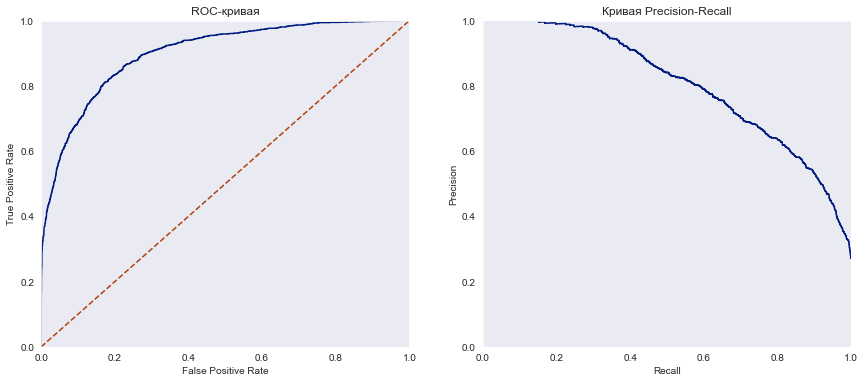

In [84]:
cat_curce = cross_val_predict(best_model_cat[-1], features_train, target_train, cv = 3, method='predict_proba')[:,1]
curve_graphs(target_train, lgbm_curce)

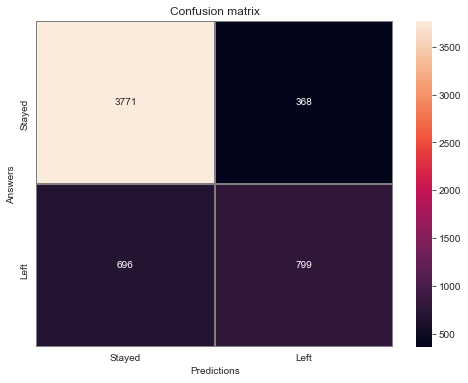

In [85]:
cat_mat_for = cross_val_predict(best_model_cat[-1], features_train, target_train, cv = 3)
conf_mat(target_train, cat_mat_for, ['Stayed', 'Left'])  

In [86]:
# Создадим датафрейм с результатами модели, потом так будет проще искать лучшую модель
cat_table = pd.DataFrame.from_dict(best_scores_cat[-1]).T
cat_table['CatBoost'] = (cat_table[0]+cat_table[1]+cat_table[2])/3
cat_table = cat_table.drop([0,1,2], axis = 1)
cat_table

CatBoost
fit_time                0.013174
score_time              0.005877
test_accuracy           0.811147
test_precision          0.685573
test_recall             0.534456
test_f1                 0.600033
test_roc_auc            0.856869
test_average_precision  0.700775

<div style="border:solid grey 1px; padding: 20px"> 
Модель градиентного бустинга CatBoostClassifier гиперпараметрами Глубина = 5  на кросс-валидации данных получила roc_auc 0.857 и accuracy 0.811.
Модель показывает довольно хороший показатель recall 0.534 и средний precision: 0.686, то есть модель определяет 53% всех уходящих пользователей, но почти 32% из тех кого модель определяет как уходящих на самом деле не уходят.
    
Эта модель уступает LGBMClassifier

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Шаг 4  Проверка финальной модели (LightGBM)</h3>
<a id="best"></a>
</div>

In [87]:
# Создадим датафрейм с результатами всех моделей и определим лучшую модель

best_models = log_table.merge(tree_table, left_index=True, right_index=True)\
                       .merge(for_table, left_index=True, right_index=True)\
                       .merge(lgbm_table, left_index=True, right_index=True)\
                       .merge(cat_table, left_index=True, right_index=True)\

best_models = best_models.T.sort_values(by = 'test_roc_auc', ascending = False)
best_models

fit_time  score_time  test_accuracy  test_precision  \
lgbm                    0.031628    0.011406       0.826766        0.643683   
forrest                 0.224254    0.044078       0.789492        0.581745   
CatBoost                0.013174    0.005877       0.811147        0.685573   
DecisionTreeClassifier  0.006359    0.004766       0.770856        0.552170   
LogReg                  0.013330    0.005445       0.751331        0.521413   

                        test_recall   test_f1  test_roc_auc  \
lgbm                       0.779285  0.704813      0.899902   
forrest                    0.741146  0.651284      0.860729   
CatBoost                   0.534456  0.600033      0.856869   
DecisionTreeClassifier     0.760526  0.638608      0.845637   
LogReg                     0.793978  0.628989      0.841755   

                        test_average_precision  
lgbm                                  0.806353  
forrest                               0.720346  
CatBoost                              0.700775  
DecisionTreeClassifier                0.676830  
LogReg                                0.650019

<div style="border:solid grey 1px; padding: 20px"> 
Лучшая модель - градиентый бустинг от Майкрософт (LightGBM), она лучшую целевую метрику roc_auc на кросс валидации, также по всем остальным метрикам она занимает 1 или второе места. Так по accuracy она на перовм месте с результатом 0.83, на втором по precision 0.643 (после CatBoost), на втором по recall 0.779 (после логистической регрессии), первое место по f1 0.7.

</div>

In [88]:
def metrics(target, predict): # Напишем функцию, которая будет принимать прогнозы и ответы 
# и будет печатать нам показатели 

    print('Полнота:{:.3f}'.format(recall_score(target, predict))) # рассчтитали метрики
    print('Точность:{:.3f}'.format(precision_score(target, predict)))
    print('Accuracy:{:.3f}'.format(accuracy_score(target, predict)))
    print('f1_score:{:.3f}'.format(f1_score(target, predict)))

In [89]:
best_model = best_model_lgbm[-1]
best_model.fit(features_train, target_train)
probalities = best_model.predict_proba(features_test)[:,1]
predictions = best_model.predict(features_test)

metrics(target_test, predictions)

ap = average_precision_score(target_test, probalities)
auc_roc = roc_auc_score(target_test, probalities)
metrics
print()
for treshold in np.arange(0.3, 0.8, 0.05):
    predicted_test=probalities>treshold
    f1 = f1_score(target_test, predicted_test)
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)  
    accuracy = accuracy_score(target_test, predicted_test)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, Accuracy:{:.3f}, f1_score = {:.3f}"\
                  .format(treshold, precision, recall, accuracy, f1))

print()
print('Общие показатели модели')
print('Auc-Roc: {:.3f}, Average precision score: {:.3f}'.format(auc_roc, ap))

Полнота:0.824
Точность:0.657
Accuracy:0.839
f1_score:0.731

Порог = 0.30 | Точность = 0.530, Полнота = 0.904, Accuracy:0.762, f1_score = 0.668
Порог = 0.35 | Точность = 0.556, Полнота = 0.890, Accuracy:0.782, f1_score = 0.684
Порог = 0.40 | Точность = 0.589, Полнота = 0.861, Accuracy:0.803, f1_score = 0.699
Порог = 0.45 | Точность = 0.632, Полнота = 0.845, Accuracy:0.828, f1_score = 0.723
Порог = 0.50 | Точность = 0.657, Полнота = 0.824, Accuracy:0.839, f1_score = 0.731
Порог = 0.55 | Точность = 0.689, Полнота = 0.805, Accuracy:0.852, f1_score = 0.742
Порог = 0.60 | Точность = 0.720, Полнота = 0.765, Accuracy:0.859, f1_score = 0.742
Порог = 0.65 | Точность = 0.764, Полнота = 0.746, Accuracy:0.872, f1_score = 0.755
Порог = 0.70 | Точность = 0.784, Полнота = 0.679, Accuracy:0.865, f1_score = 0.728
Порог = 0.75 | Точность = 0.811, Полнота = 0.618, Accuracy:0.860, f1_score = 0.701

Общие показатели модели
Auc-Roc: 0.911, Average precision score: 0.829


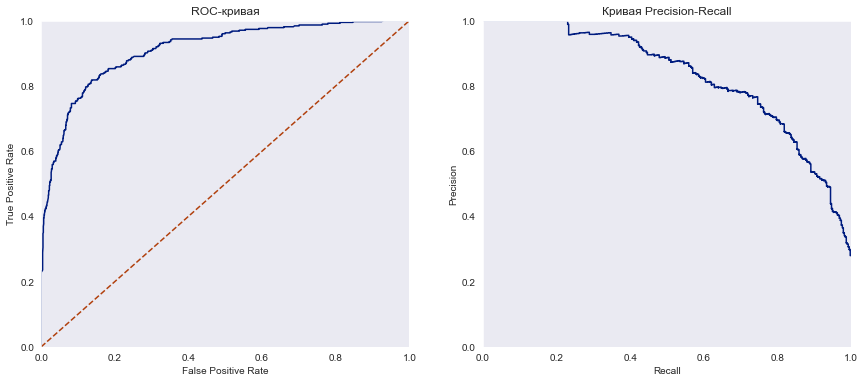

In [90]:
curve_graphs(target_test, probalities)

<div style="border:solid grey 1px; padding: 20px"> 

Лучшая модель - градиентый бустинг от Майкрософт (LightGBM) на тестовой выборке она показала результат показателя Auc-Roc: 0.911 и Accuracy:0.839 и Полнота предсказаний составляет 0.824. Получается в 84% случаях модель дает верный ответ и определяет 82% уходящих клиентов. При этом резултат Accuracy можно довести до 87%, если сдвинуть порог вероятностей, при котором модель решает, уйдет клиент или нет, до 65% вместо 50%. Также опционально мы можем повысить долю полнуту предсказаний (модель станет меньше пропускать тех, кто может покинуть сервис), если будем опускать этот порог вероятности. При этом мы будем терять в точности предсказаний (то есть получис больше ложных срабатываний. Например, при стандатрном пороге Полнота = 0.805, Точность = 0.689, Accuracy:0.839. Если мы опустим попрог до 30, то получим показатели Полнота = 0.904, Точность = 0.530, Accuracy:0.762. Получается мы пропустим меньше уходящих, но также вероятность определить как уходящего того, кто останется также возрастает.

</div>

<div style="border:solid blue 2px; padding: 20px"> 
<h3 style="color:blue;margin-bottom:10px">Вывод</h3>

Нами был получен набор данных из 4-ых датасетов. В каждом из них было от 5 до 7 тыс. наблюдений. Мы получили большое количество признаков (17 шт). Данные были достаточно чистые, пропусков было не очень много, отсутствовали дубликаты, существенных выбросов и нереалистичных значений также не было.
    
В рамках подготовки данных для предсказывания уходящих клиентов мы объединили все датасеты в один, заполнили пропуски, убрали незначимые признаки, сгенерировали новые признаки исзодя из наших данных, провели кодирование качественных признаков и нормирование количетсвенных. Далее мы разбили данные на тестовую и обучающую выборки.
    
Мы обучили типов 5 моделей (Логистическую регрессию,Решающее дерево, Случайный лес и два градиентных бустинга (LightGBM от майкрософт и CatBoost яндекса). При обучении моделей мы перебрали большое количество гиперпараметров. Также  для обучения моделей мы использовали кросс-валидацию, разбивая обучающую выборку на 3 группы. Целевым признаком для нас являлся Auc-Roc, но конечно мы обращали внимание на такие метрики как Accuracy, Precision (точность) и Recall (полноста).
    
Лучшая модель - градиентый бустинг от Майкрософт (LightGBM) на тестовой выборке она показала результат показателя Auc-Roc: 0.911 и Accuracy:0.839 и Полнота предсказаний составляет 0.824. Получается в 84% случаях модель дает верный ответ и определяет 82% уходящих клиентов. При этом резултат Accuracy можно довести до 87%, если сдвинуть порог вероятностей, при котором модель решает, уйдет клиент или нет, до 65% вместо 50%. Также опционально мы можем повысить долю полнуту предсказаний (модель станет меньше пропускать тех, кто может покинуть сервис), если будем опускать этот порог вероятности. При этом мы будем терять в точности предсказаний (то есть получис больше ложных срабатываний. Например, при стандатрном пороге Полнота = 0.805, Точность = 0.689, Accuracy:0.839. Если мы опустим попрог до 30, то получим показатели  Полнота = 0.904, Точность = 0.530, Accuracy:0.762. Получается мы пропустим меньше уходящих, но также вероятность определить как уходящего того, кто останется также возрастает. 
    
Для конкретных рекомендаций, какой именно порог нужно выставлять нужно получить больше данных о том, как дорого нам обходится один ушедший и какие издержки компания будет получать если будет давать скидки тем, кого мы определим как уходящих, которые ими не являются.
    
Однако, можно с уверенностью сказать, что лучшей моделью является градиентый бустинг от Майкрософт (LightGBM), по показателю Auc-Roc (и его графику), что 90% просранства находится по графиком, а значит даже при изменениях порога вероятности для определения значения модель будет показывать довольно хорошие результаты.
    
<a id="conc"></a>
</div>